# My first chemistry autoencoder

### Imports

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import os
import pandas as pd

import torch
import torch.nn          as nn
from torch.utils.data    import Dataset, DataLoader
from torch.optim         import Adam

from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150

In [2]:
specs_file = '/lhome/silkem/CHEM/src-IP-AP-HNR/specs/rate16_IP_6000K_Crich_mean_Htot.specs'

idxs, mols = np.loadtxt(specs_file, usecols=(0,1), unpack = True, max_rows=466, skiprows=1, dtype='str')

molecs = dict()
for i in range(len(idxs)):
    molecs[mols[i]] = int(idxs[i])-1

### Classes

In [3]:
'''
Class to initialise the dataset to train & test emulator
'''
class MyDataset(Dataset):
    '''
    Get data from textfiles (output CSE model)
    
    Preprocess:
        - set all abundances < cutoff to cutoff
        - take np.log10 of abudances

    '''
    def __init__(self, dir=None, file=None, train=True, fraction=0.7, cutoff = 1e-40, scale = 'norm'):
        data = []

        if dir != None:
            locs = os.listdir(dir) 

            for i in range(1,len(locs)+1):
                name = dir+'csfrac_smooth_'+str(i)+'.out'
                proper = MyDataset.read_data(name)
                data.append(proper)
        
        if file != None:
            proper = MyDataset.read_data(file)
            data.append(proper)

        df = np.concatenate(data)
        
        ## Clip and take log10
        self.df = np.clip(df, cutoff, 1)
        self.df = np.log10(self.df)

        ## Statistics of the data
        self.mean = np.mean(self.df)
        self.std  = np.std(self.df)
        self.min  = np.min(self.df)
        self.max  = np.max(self.df)

        ## Normalise 
        if scale == 'norm':
            self.df = (self.df - self.mean ) / (self.std)

        ## Scale
        if scale == 'minmax':
            self.df = (self.df - self.min) / (np.abs( self.min - self.max ))
        
        ## Original data
        if scale == None:
            self.df = self.df

        ## Set type
        self.df   = self.df.astype(np.float32)
        self.mean = self.mean.astype(np.float32)
        self.std  = self.std.astype(np.float32)
        self.min  = self.min.astype(np.float32)
        self.max  = self.max.astype(np.float32)

        ## Split training - testing data
        N = int(fraction * self.df.shape[0])
        if train:
            self.df = self.df[:N]
        else:
            self.df = self.df[N:]
            
            
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        return self.df[idx]

    def get_stats(self):
        return self.mean, self.std, self.min, self.max

    
    '''
    Read data text file of output abundances of 1D CSE models
    '''
    @staticmethod
    def read_data(file_name):
        with open(file_name, 'r') as file:
            dirty = []
            proper = None
            for line in file:
                try:  
                    if len(line) > 1: 
                        dirty.append([float(el) for el in line.split()])
                except:
                    if len(dirty) != 0:
                        dirty = np.array(dirty)[:,1:]
                        if proper is None:
                            proper = dirty
                        else:
                            proper = np.concatenate((proper, dirty), axis = 1)
                    dirty = []
        return proper

    

In [4]:
class Encoder(nn.Module):
    """
    Encoder network.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.layer1 = nn.Linear( input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.layer1(x))
        h = self.LeakyReLU(self.layer2(h))
        h = self.LeakyReLU(self.layer3(h))
        h = self.LeakyReLU(self.layer4(h))
        return h
    
    
class Decoder(nn.Module):
    """
    Decoder network.
    """
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.layer1 = nn.Linear(latent_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.layer1(x))
        h = self.LeakyReLU(self.layer2(h))
        h = self.LeakyReLU(self.layer3(h))
        h = self.LeakyReLU(self.layer4(h))
        return h
    
    
class Autoencoder(nn.Module):
    """
    Autoencoder.
    """
    def __init__(self, Encoder, Decoder):
        super(Autoencoder, self).__init__()
        
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        h = self.Encoder(x)
        h = self.Decoder(h)
        return h

### Functions

In [5]:
def plot_hist(df):

    fig = plt.figure(figsize = (10,4))
    ax1 = fig.add_subplot((111))

    for i in range(df.shape[1]):
        ax1.hist(df[:,i].ravel(), bins = 100, histtype='step')

    # ax1.set_yscale('log')
    ax1.set_xlabel('normalised log abundance')
    ax1.set_ylabel('#')

    plt.show()

    return

def plot_loss(train, test, log = True):
    fig = plt.figure(figsize = (10,4))
    ax1 = fig.add_subplot((111))

    ax1.plot(train, ls = '-'    , c='k', lw = 1)
    ax1.plot(train, ls = None, marker = '.', c='royalblue', label = 'train')

    ax1.plot(test, ls = '-'    , c='k', lw = 1)
    ax1.plot(test, ls = None, marker = '.', c='firebrick', label = 'test')

    if log == True:
        ax1.set_yscale('log')

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('MSE')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(loc = 'upper right')

    plt.show()

    return

def plot_compare(real,pred, specs = None, scale = 'norm'):

    fig = plt.figure(figsize = (5,5))
    ax1 = fig.add_subplot((111))

    if specs == None:
        for spec in molecs:
            ax1.scatter(real[:,molecs[spec]] ,pred[:,molecs[spec]]  , marker = '.', label = spec, alpha = 0.6)
    else:
        for spec in specs:
            ax1.scatter(real[:,molecs[spec]] ,pred[:,molecs[spec]]  , marker = '.', label = spec, alpha = 0.6)

    if scale == 'norm':
        line = [-3,2]
    if scale == 'minmax':
        line = [0,1]
        
    ax1.plot(line,line, '--k', lw = 1)

    ax1.set_xlabel('real')
    ax1.set_ylabel('predicted')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend()

    plt.show()

def plot_fracs_profile(rad, real, pred, spec, lw = 1):
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [5,2]},figsize=(5,5))
    ## first row
    ax1 = ax[0]
    ax2 = ax[1]
    axs = [ax1,ax2]

    ax1.set_title(spec)

    idx = molecs[spec]

    ax1.plot(rad,real[:,idx], label = 'real'     , lw = lw, c = 'royalblue')
    ax1.plot(rad,pred[:,idx], label = 'predicted by autoencoder', lw = lw, c = 'firebrick')
    ax2.plot(rad,np.abs(real[:,idx]-pred[:,idx]),'--k', lw=lw)
    for ax in axs:
        ax.set_xscale('log')
        ax.grid(True, linestyle = '--', linewidth = 0.2)
        ax.set_yscale('log')
    ax1.set(xticklabels=[])

    ax2.set_xlabel('Radius (cm)')
    ax1.set_ylabel('Fractional abundance w.r.t. H')
    ax2.set_ylabel('Residual')

    ax1.legend(loc = 'lower left')

    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.07)

    plt.show()
    return


In [6]:
def loss_function(x, x_hat):
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    return reproduction_loss

'''
x = dataset in PyTorch tensor form
'''
def get_unscaled(Dataset, x, scale):
    mean, std, min, max = Dataset.get_stats()

    if scale == 'norm':
        unscale = x*(std) + mean
    if scale == 'minmax':
        unscale = x*np.abs(min-max) + min
    
    return unscale

'''
Function to compare an abundance profile with the autoencoded version.
'''
def test_abundance_profile(dir, label, model, scale = 'norm'):
    physpar = pd.read_fwf(dir+'csphyspar_smooth_'+label+'.out', )
    test_fracs = MyDataset(file=dir+'csfrac_smooth_'+label+'.out', fraction=1, scale = scale)
    
    rad = physpar['RADIUS']

    df_tensor = DataLoader(dataset=test_fracs, batch_size=len(test_fracs), shuffle=False ,  **kwargs)

    model.eval()

    with torch.no_grad(): 
        for x in df_tensor:
            x_hat = model(x.to(DEVICE))

    pred = 10**get_unscaled(test_fracs, x_hat, scale)
    real = 10**get_unscaled(test_fracs, x    , scale)

    return rad, real, pred


### Data: train & test

In [7]:
dir = '/lhome/silkem/MACE/MACE/train_data_C/'

In [8]:
## Make PyTorch dataset
train = MyDataset(dir=dir, scale = "norm")
test  = MyDataset(dir=dir, scale = "norm", train = False)
 
print('total # of samples:',len(train)+len(test))
print('# training samples:',len(train))
print('# testing samples: ',len(test) )
print('            ratio: ',np.round(len(test)/(len(train)+len(test)),2))


total # of samples: 2187
# training samples: 1530
# testing samples:  657
            ratio:  0.3


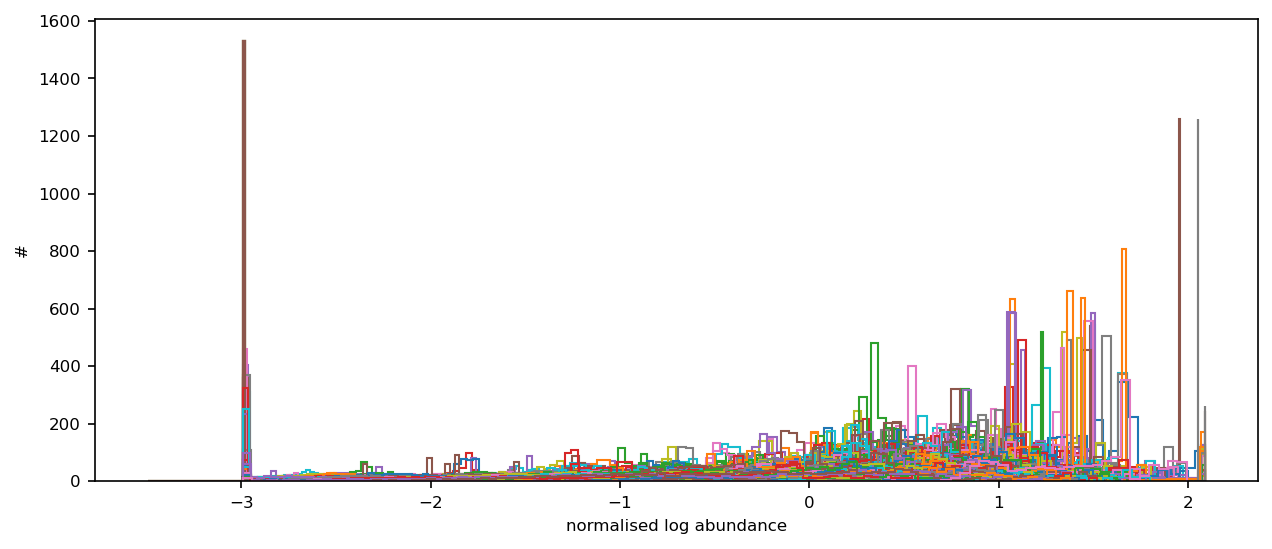

In [9]:
plot_hist(train.df)

### Model hyperparameters

In [10]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim

## Set up training hyperparams
batch_size = 100
lr = 1e-3                   ## learning rate
epochs = 100

### Training

In [11]:
## Make PyTorch tensor objects from the data set to train

kwargs = {'num_workers': 1, 'pin_memory': True} 

data_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True ,  **kwargs)
test_loader = DataLoader(dataset=test , batch_size=len(test) , shuffle=False,  **kwargs)


In [12]:
## Build model

encoder = Encoder( input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, output_dim)

model = Autoencoder(Encoder=encoder, Decoder=decoder).to(DEVICE)        # GPU/TPU/... --> XPU


In [13]:

def train_one_epoch(data_loader):
    
    overall_loss = 0
    
    for i, x in enumerate(data_loader):
           
        x     = x.to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device

        x_hat = model(x)         ## output van het autoecoder model

        ## Calculate losses
        loss  = loss_function(x,x_hat)
        overall_loss += loss.item()

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return (overall_loss)/(i+1)  ## save losses



def validate_one_epoch(test_loader):

    overall_loss = 0

    with torch.no_grad():
        for i, x in enumerate(test_loader):

            x     = x.to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device

            x_hat = model(x)         ## output van het autoecoder model

            ## Calculate losses
            loss  = loss_function(x,x_hat)
            overall_loss += loss.item()

        return (overall_loss)/(i+1)  ## save losses


In [14]:
## Training & validating model

optimizer = Adam(model.parameters(), lr=lr)

loss_train_all = []
loss_test_all  = []

for epoch in range(epochs):

    ## Training
    model.train()

    train_loss = train_one_epoch(data_loader)
    loss_train_all.append(train_loss)  ## save losses

    ## Validating
    model.eval() ## zelfde als torch.no_grad

    test_loss = validate_one_epoch(test_loader)
    loss_test_all.append(test_loss)
    
    print("\tEpoch", epoch + 1, "complete!", "\tAverage loss train: ", train_loss, "\tAverage loss test: ", test_loss, end="\r")

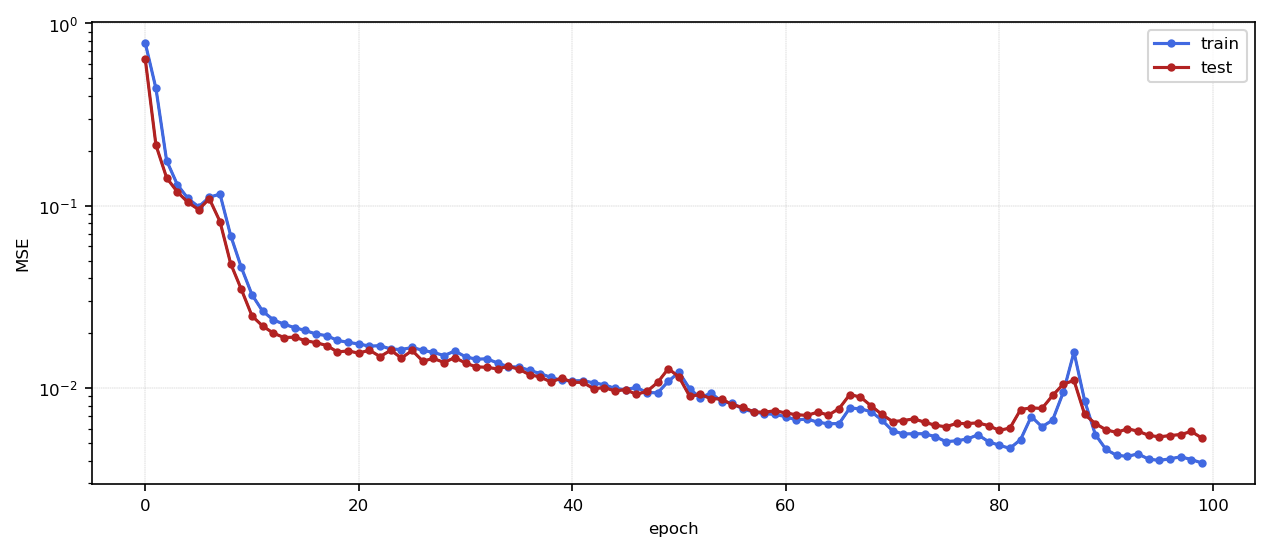

In [15]:
plot_loss(loss_train_all, loss_test_all)

In [16]:
## Testing model

overall_loss = 0

with torch.no_grad():
    for i, x in enumerate(test_loader):

        x_test     = x.to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device

        x_test_hat = model(x)         ## output van het autoecoder model

        ## Calculate losses
        loss  = loss_function(x_test,x_test_hat)
        overall_loss += loss.item()

print('loss:',(overall_loss)/(i+1))
        

loss: 0.005306879989802837


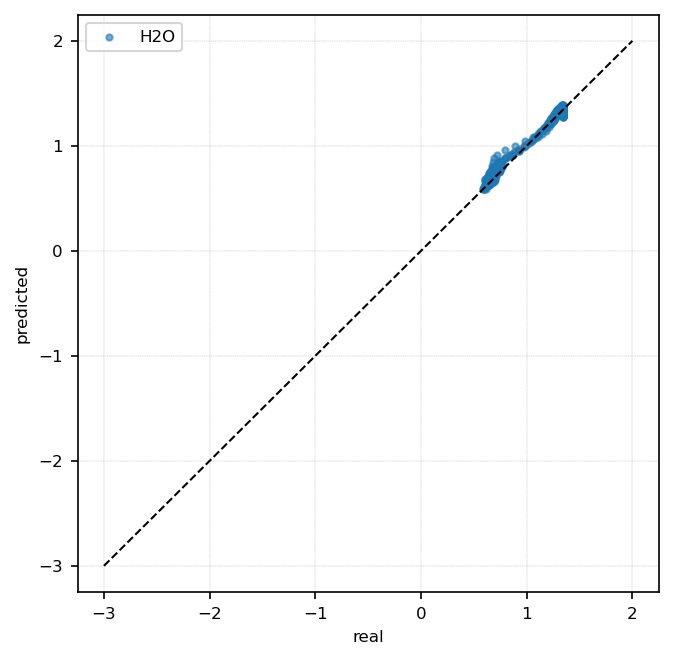

In [17]:
plot_compare(x_test,x_test_hat, ['H2O'])


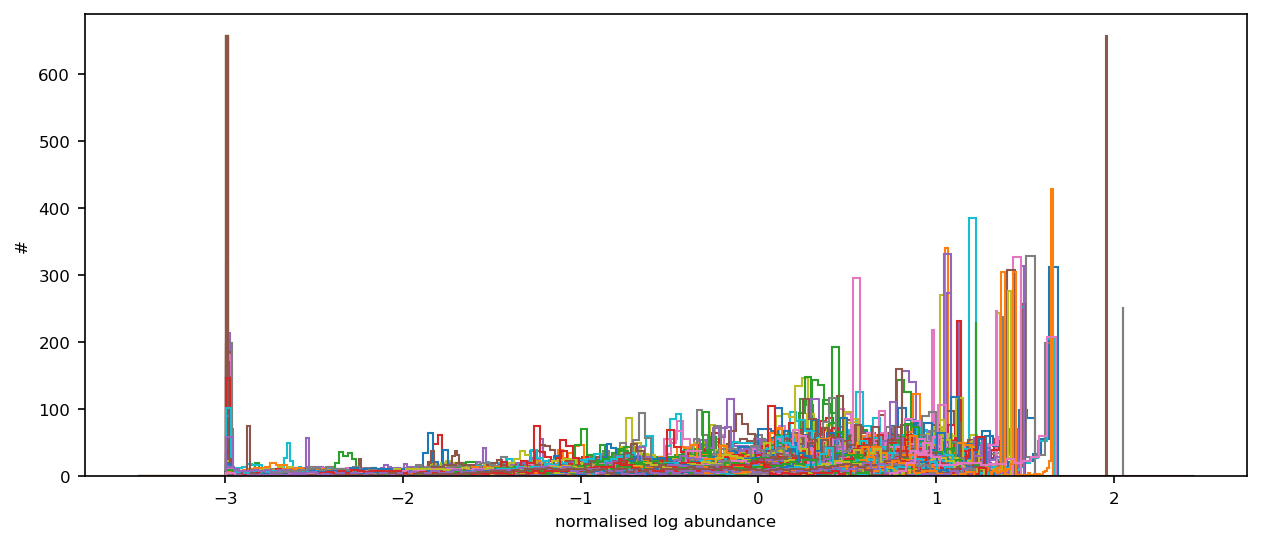

In [18]:
plot_hist(x_test)

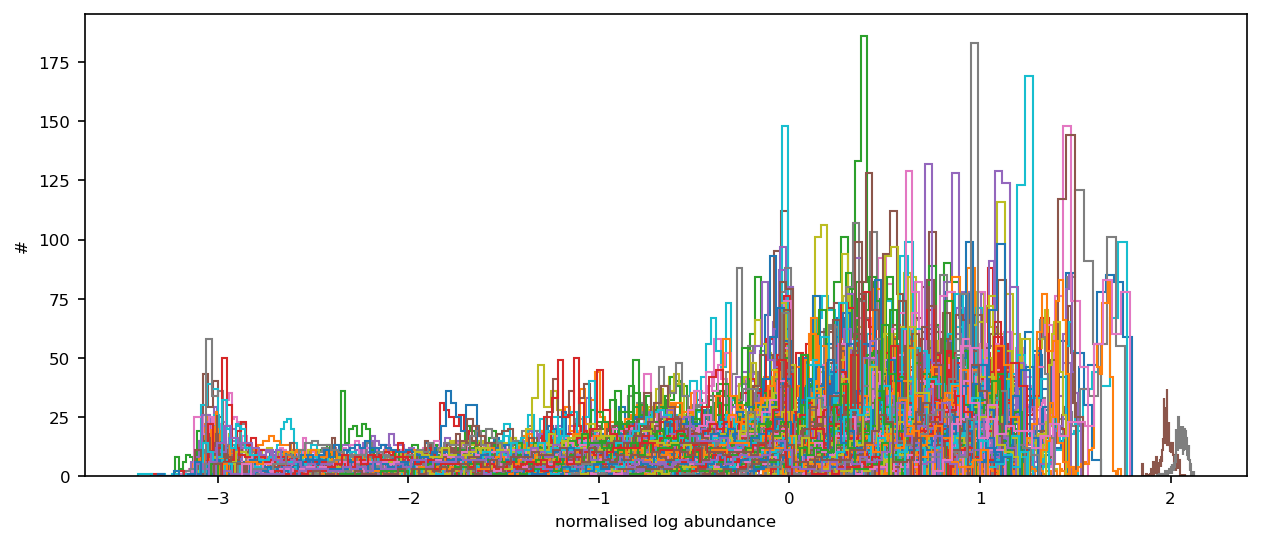

In [19]:
plot_hist(x_test_hat)

## Comparison of abundance profile

In [20]:
dir_test = '/lhome/silkem/MACE/MACE/test_data/'

In [21]:
rad, real, pred = test_abundance_profile(dir_test, 'test', model, scale = 'norm')

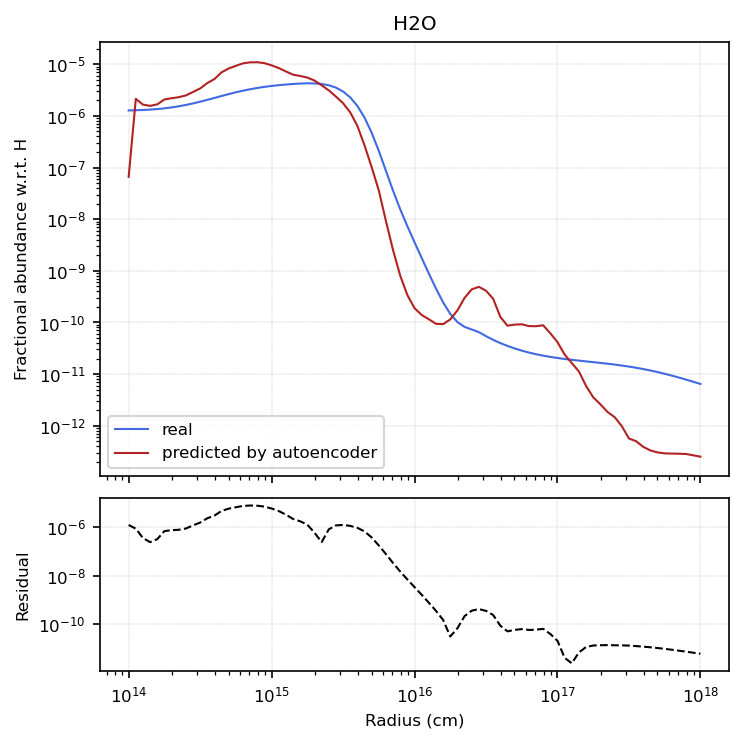

In [23]:
plot_fracs_profile(rad, real, pred, 'H2O')